In [1]:
import os
import cv2
import glob
import torch
import datetime
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

/home/bcca/anaconda3/envs/spectre/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!gdown -O cityscape128.zip "https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download"

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download
From (redirected): https://drive.google.com/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download&confirm=t&uuid=d25c3f67-e1af-453b-b7b3-48f1986ce1cc
To: /home/bcca/Desktop/ATHARVA/cityscape128.zip
100%|██████████████████████████████████████| 50.1M/50.1M [00:01<00:00, 29.4MB/s]


In [3]:
!unzip cityscape128.zip

Archive:  cityscape128.zip
   creating: segdata128/
   creating: segdata128/reduced_mask/
   creating: segdata128/reduced_mask/train/
  inflating: segdata128/reduced_mask/train/2815.jpg  
  inflating: segdata128/reduced_mask/train/2668.jpg  
  inflating: segdata128/reduced_mask/train/1143.jpg  
  inflating: segdata128/reduced_mask/train/410.jpg  
  inflating: segdata128/reduced_mask/train/724.jpg  
  inflating: segdata128/reduced_mask/train/1515.jpg  
  inflating: segdata128/reduced_mask/train/2723.jpg  
  inflating: segdata128/reduced_mask/train/1360.jpg  
  inflating: segdata128/reduced_mask/train/488.jpg  
  inflating: segdata128/reduced_mask/train/2577.jpg  
  inflating: segdata128/reduced_mask/train/1842.jpg  
  inflating: segdata128/reduced_mask/train/2524.jpg  
  inflating: segdata128/reduced_mask/train/800.jpg  
  inflating: segdata128/reduced_mask/train/2338.jpg  
  inflating: segdata128/reduced_mask/train/743.jpg  
  inflating: segdata128/reduced_mask/train/2183.jpg  
  infla

In [4]:
# Data path
INPUT_PATH = './segdata128/reduced'
INPUT_PATH_MASK = './segdata128/reduced_mask'

In [5]:
import random

random.seed(10)

## Parameters

In [6]:
INPUT_IMG_SIZE = 128

OUTPUT_CLASSES = 12

LEARINING_RATE = 0.01

OPIMIZER_NAME = 'Adam'

SCHEDULER_NAME = 'stepLR'

BATCH_SIZE = 8

MAX_EPOCHS = 10

AUGMENTATION = False

MEAN = None

STD = None

THRESH_ACC_CKP = 0.9

SCHEDULER_STEP_SIZE = 4

USE_CUDA = torch.cuda.is_available()

## Data preprocessing

In [7]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
train_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))

print('Total train images:', len(train_files))

print('Total train mask:', len(train_files_mask))

print('Total test images:', len(test_files))
print('Total test mask:', len(test_files_mask))



Total train images: 2975
Total train mask: 2975
Total test images: 500
Total test mask: 500


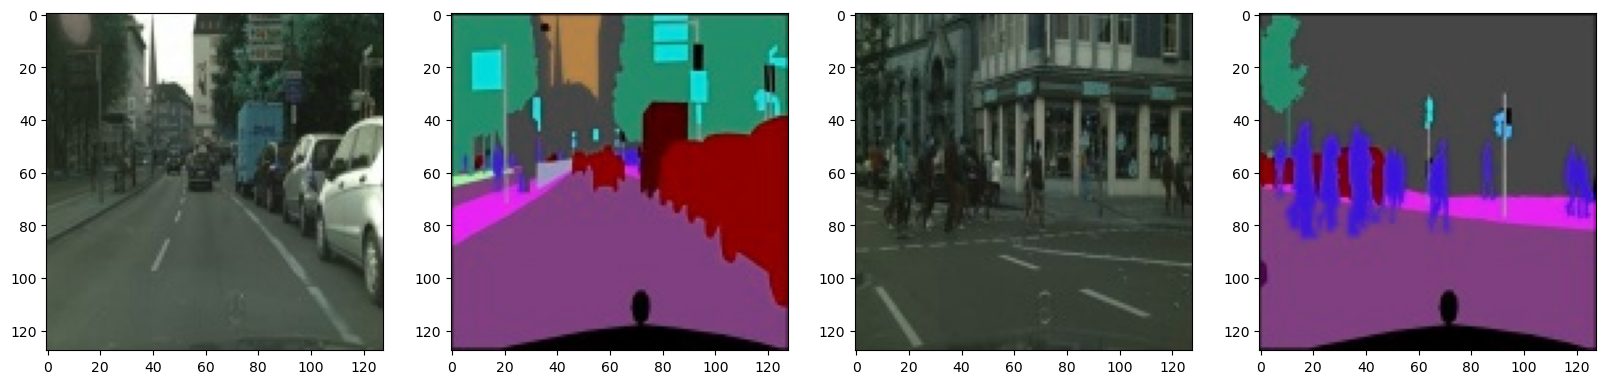

In [8]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    if(i%2==0):
      img = cv2.imread(train_files[i//2])
      ax.imshow(img)
    else:
      mk = cv2.imread(train_files_mask[i//2])
      ax.imshow(mk)
    # break
    #ax.axis('off')
plt.show()

### As you can observe:

*  Masks are in the RGB format
*  The Number of segmented classes is changing in every mask (non uniform class number in the label data).
*  Masks are not encoded

### Preparation:

*  Using Kmeans algorithm --> clustering the unique colors present in a mask
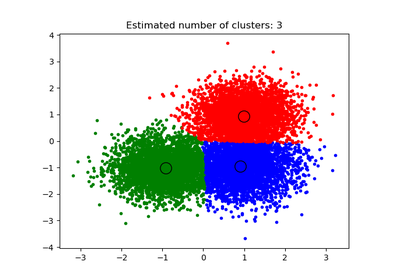

*  Use trained Kmeans to encode RGB mask as color encoded mask

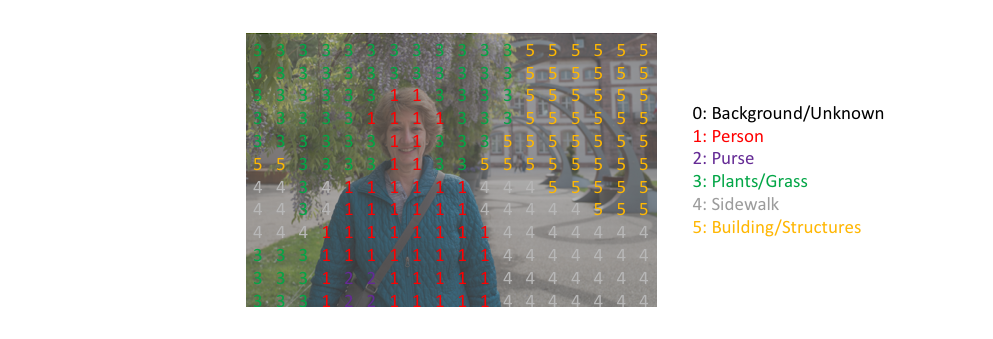

*  As illustated in the above example, every object in that image has been encoded with a specific number
*  We are also doing the same thing by using kmeans

## Mask encoding

* **bold text** We are going to use 50 masks as training data for clustering
* (50, 256, 256, 3) --> (50 x 256 x 256, 3) --> (3276800, 3)
* We have 3276800 data points (3 --> RGB values) for clustering
* Using 12 kmeans clusters

In [9]:
kmeans_data = []
for i in train_files_mask[:50]:
    org_img = cv2.imread(i)

    msk = org_img
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

(819200, 3)


In [10]:
# train kmeans with 12 clusters
encoder = KMeans(n_clusters=OUTPUT_CLASSES)
encoder.fit(kmeans_data)

/home/bcca/anaconda3/envs/spectre/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12)

In [11]:
encoder.cluster_centers_

array([[127.2340818 ,  63.92073812, 128.2990051 ],
       [  6.49280379,   4.78740815,   6.52224145],
       [ 67.71684321,  70.86107439,  70.08591252],
       [219.17035536,  42.72196252, 231.4624788 ],
       [161.9856546 , 237.86545961, 164.93551532],
       [ 43.71281444, 138.78000801, 108.00906375],
       [133.95027246,   2.85076474,   5.51738753],
       [166.46170265, 127.7686948 ,  79.5608685 ],
       [ 72.49461678,  16.77061108,  79.67435229],
       [ 67.52914563,  31.04622648, 193.70205232],
       [156.56506659, 154.78301887, 203.83948391],
       [ 47.23456551, 201.08244629, 203.88252371]])

In [12]:
# If you have previous knowledge about the colors to be used for the classes
colors = {0: [255,0,0],
          1: [0,255,0],
          2: [0,0,255],
          3: [255,69,0],
          4: [255,0,255],
          5: [210,105,30],
          6: [192,255,62],
          7: [127,255,0],
          8: [0,238,238],
          9: [72,118,255],
          10: [72,255,255],
          11: [255,118,255]
          }

In [13]:
colors = {0:[ 42.31849768, 138.68802268, 107.34976084],
       1:[127.04043101,  64.08636608, 127.54335584],
       2:[ 67.73835184,  70.81071668,  69.68390725],
       3:[ 77.50990865,  18.95552339,  73.79703489],
       4:[133.96612288,   3.85362098,   4.37284647],
       5:[217.97385828,  43.76697629, 229.43543734],
       6:[164.94309451, 125.22840326,  81.50394562],
       7:[157.10134385, 155.26893603, 193.22678809],
       8:[ 66.53429189,  32.62107138, 188.45387454],
       9:[157.58165138, 243.49941618, 159.97381151],
       10:[  6.98127537,   5.22420501,   6.82420501],
       11:[ 48.88183862, 203.80514614, 203.66699975]
          }

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


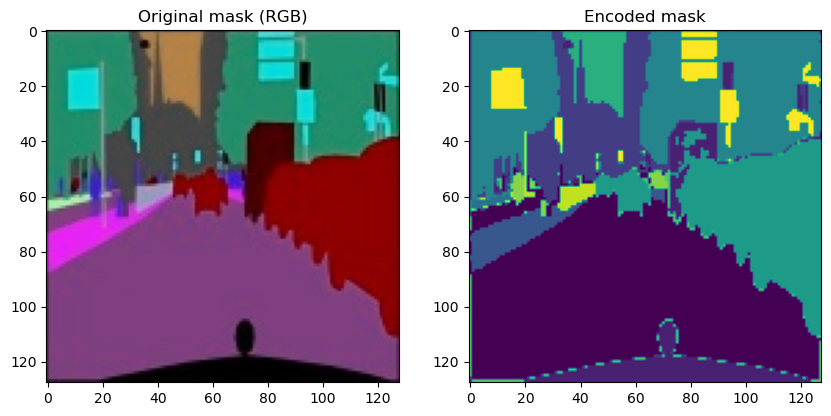

No of classes in encoded mask: [ 0  1  2  3  5  6  7  8  9 10 11]


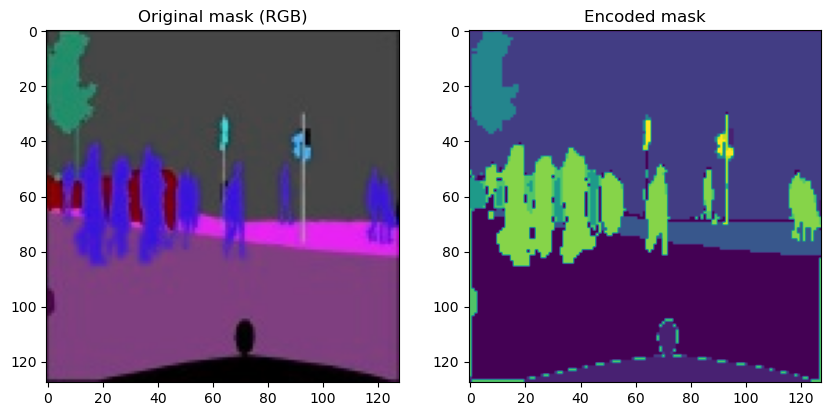

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


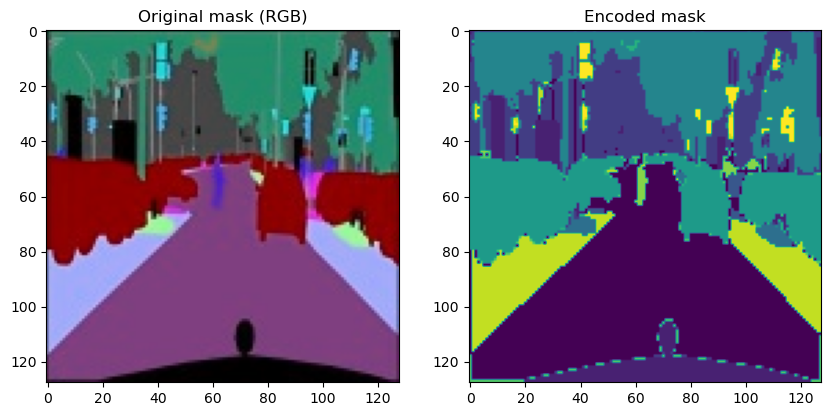

In [14]:
# encoding with trained kmeans
for i in train_files[:3]:
    org_img = cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = cv2.imread(i.replace("reduced","reduced_mask"))#org_img[:, 256:,:]      #shape (256,256,3)
    test = msk.reshape(-1,3)      #shape (65536,3)
    pred = encoder.predict(test)  #shape (65536)

    enc_pred = pred.reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE)  #shape (256,256)

    pred = np.array([colors[p] for p in pred]).reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)

    print('No of classes in encoded mask:',np.unique(enc_pred))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

## Load dataset

In [15]:
class Dataset(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [18]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)

        contracting_31_out = self.contracting_31(contracting_22_out)

        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))

        expansive_31_out = self.expansive_31(expansive_22_out)

        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out

In [19]:
nt = Net(12)

In [20]:
nt(torch.zeros(2,3,128,128)).shape

torch.Size([2, 12, 128, 128])

## Trainer

In [21]:
import tqdm
class Trainer:
    def __init__(self,
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,                # Validation (or test) data set
                 initialize_from_ckp = None,     # If you want to continue training from a specific checkpoint
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size

        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)

        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')

        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)

    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)

    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)

    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')

    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)

        return np.mean(present_iou_list),iou_list

    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []
        iou_list_list=[]
        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy,iou_list = self.IoU(labels, preds)
            iou_list_list.append(iou_list)
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item()
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)

        loss_avg = np.mean(loss_list)
        acc_avg = np.mean(acc_list)
        print(np.mean(np.array(iou_list_list),axis=0))
        return loss_avg, acc_avg

    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        iou_list_list=[]
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy,iou_list = self.IoU(labels, preds)
                iou_list_list.append(iou_list)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
            print(np.mean(np.array(iou_list_list),axis=0))
        return loss_avg, acc_avg

    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))

    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.title('loss')
        plt.show()

    def train(self):

        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []

        for epoch_counter in tqdm.tqdm(range(1, self.max_epochs+1)):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                temp_path = model_path + new_ckp
                os.makedirs(temp_path, exist_ok=True)
                if os.path.exists(temp_path):
                    self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        #self.plot_logs(train_results)

## Create dataset objects

In [34]:
train_data_obj = Dataset(train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE, True, mean=MEAN, std=STD)

In [35]:
print(train_data_obj.__len__())
print(val_data_obj.__len__())

2975
500


## Data visualization

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0706)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


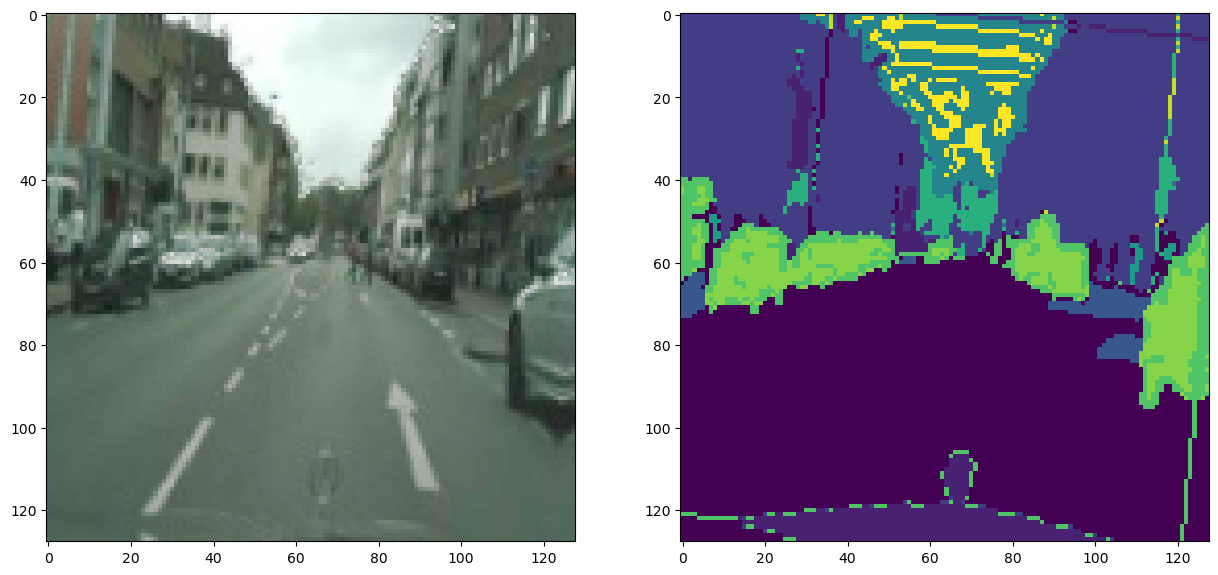

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0353)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


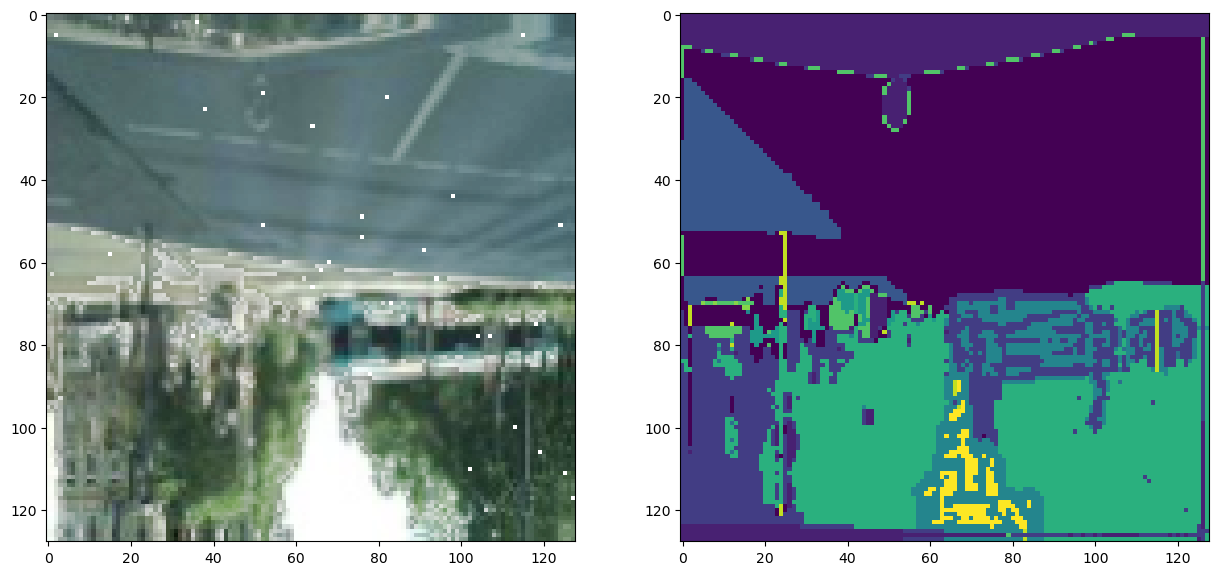

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.1098)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


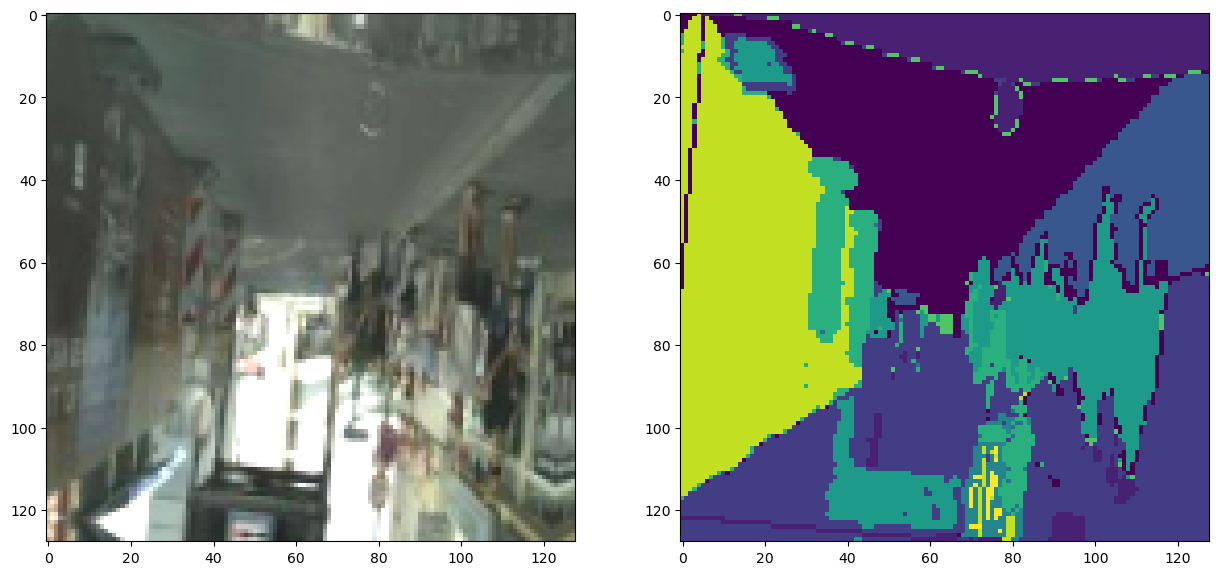

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9922) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


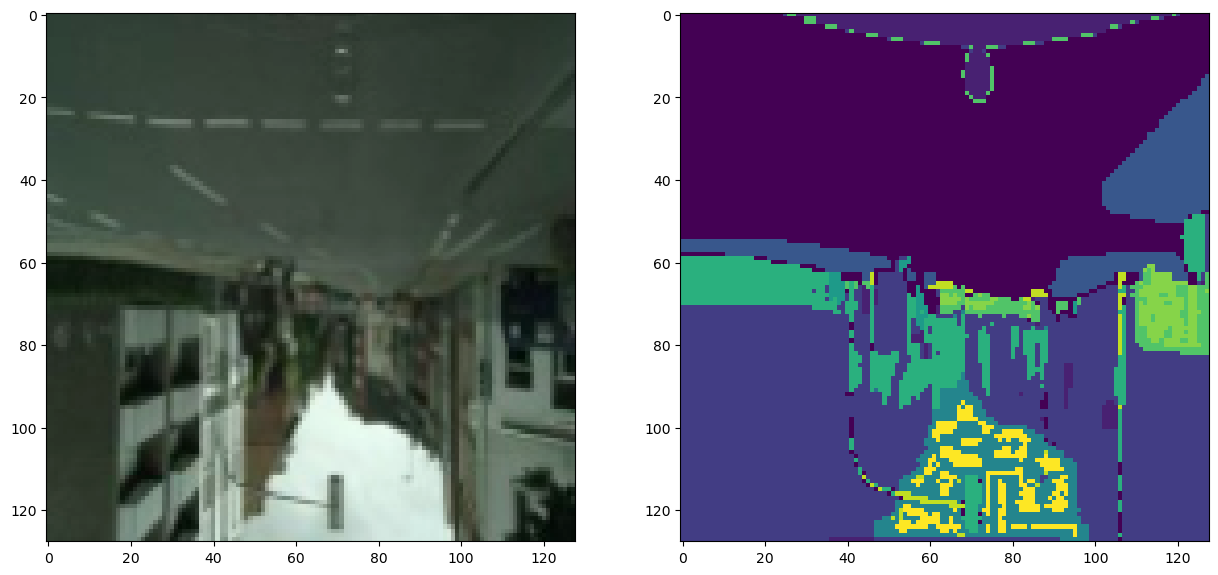

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0588)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


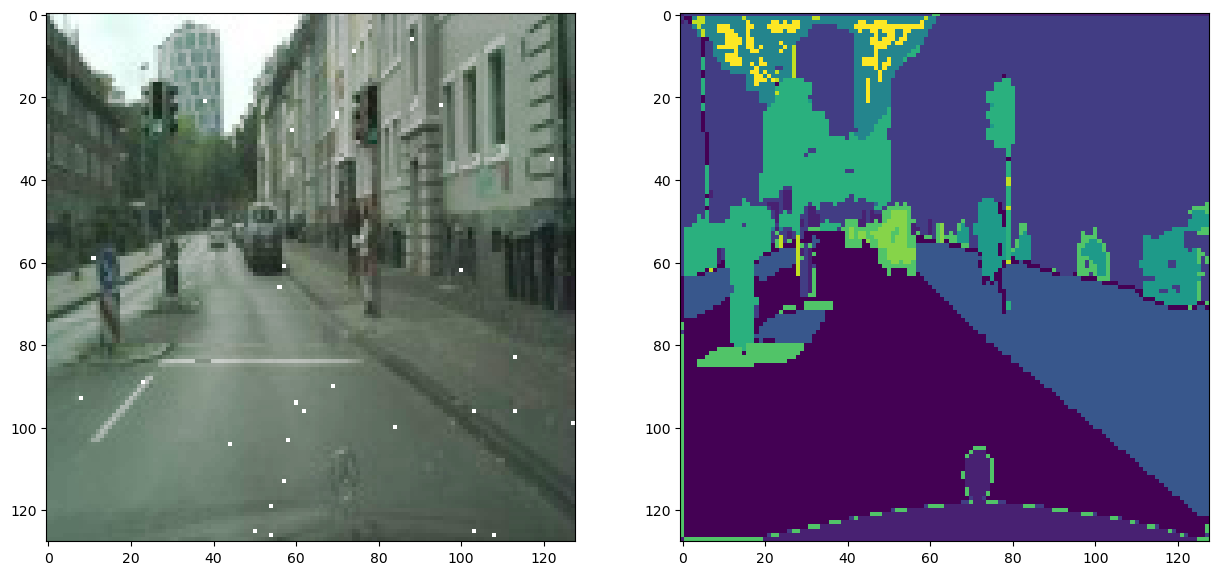

In [36]:
for i in range(5):
    img,  msk = val_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Define models

In [37]:
unet = Net(num_classes=OUTPUT_CLASSES)

## No of trainable parameters

In [38]:
print(sum(p.numel() for p in unet.parameters()))

18010252


## Define loss function

In [39]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_obj,
                  val_data = val_data_obj,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

## Start training

  0%|          | 0/10 [00:00<?, ?it/s]

[0.47132772 0.67423765        nan 0.00153972 0.05153269 0.47858089
 0.09811299 0.50780349 0.18842313 0.08633028        nan 0.41766471]
--------------------
Validation results after 1 epochs:


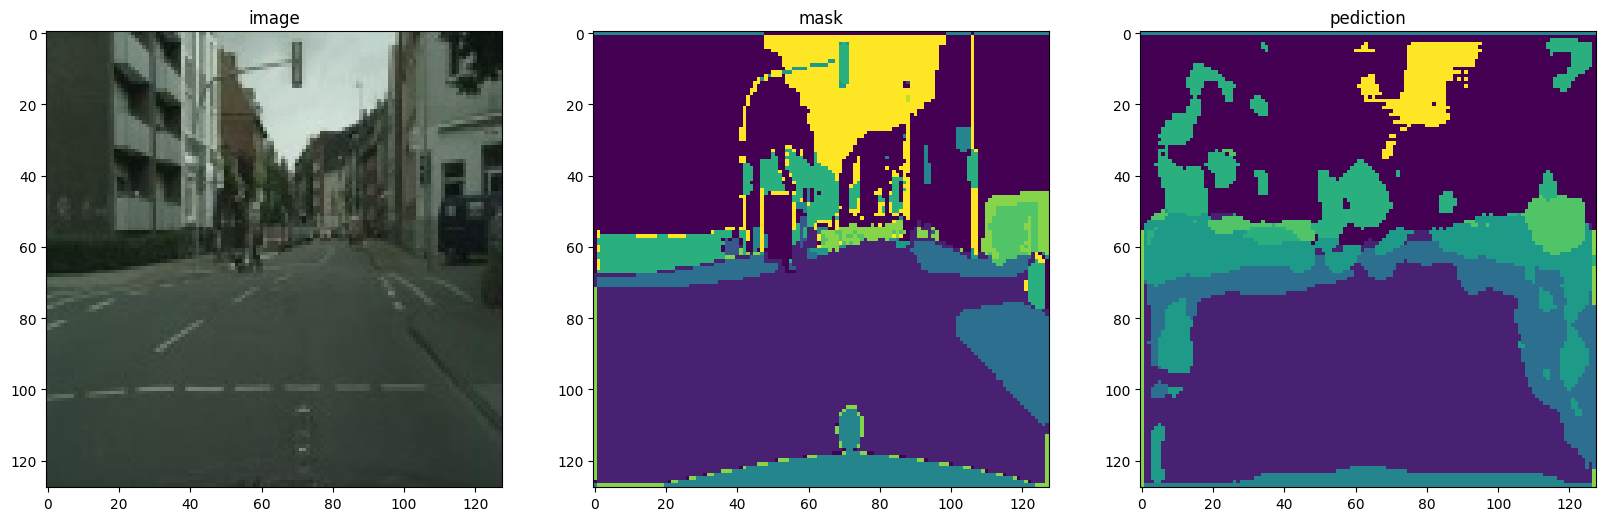

 10%|█         | 1/10 [01:16<11:29, 76.57s/it]

[0.50814477 0.55951897        nan 0.00674556 0.13403962 0.46454533
 0.10286492 0.56180087 0.24790039 0.08222002        nan 0.35830302]
[Epochs-1/10]:
[Train_loss:1.1408 | Train_acc:0.2574 | Val_loss:1.1755 | Val_acc:0.2629]
[0.56028522 0.73209383 0.         0.00866631 0.12980953 0.58948356
 0.14773686 0.57248874 0.35887334 0.13399276        nan 0.48269974]
--------------------
Validation results after 2 epochs:


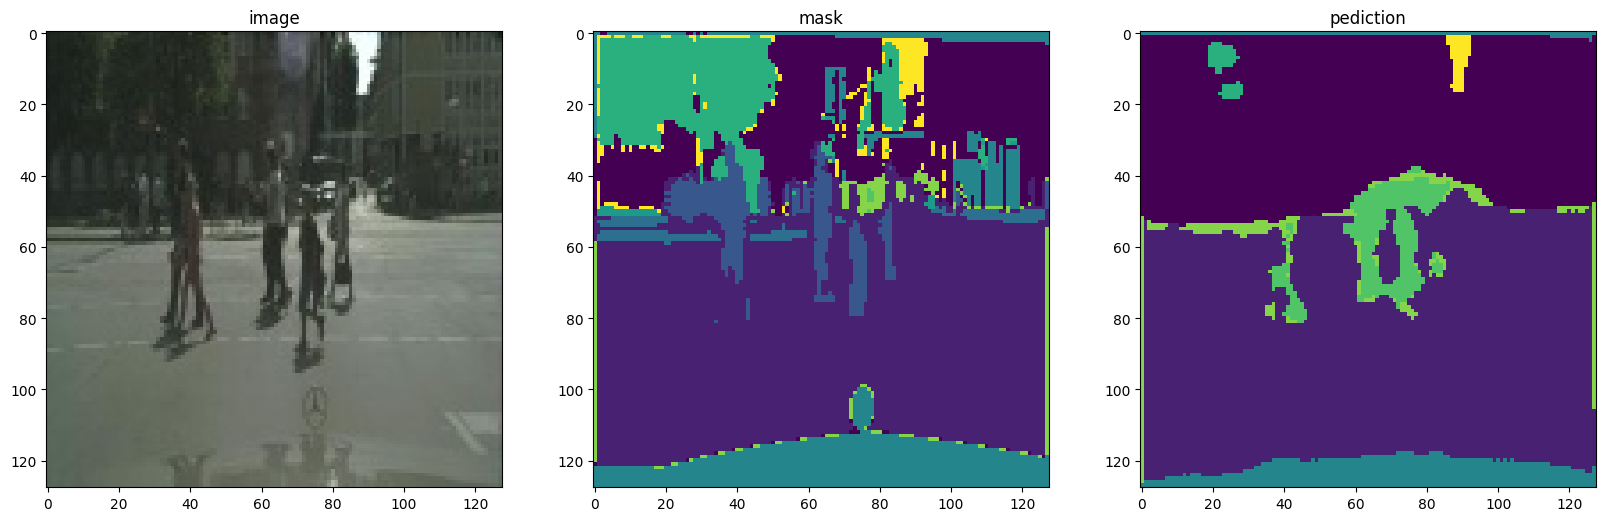

 20%|██        | 2/10 [02:36<10:30, 78.80s/it]

[0.53685461 0.68743343        nan 0.01788782 0.01454523 0.53943315
 0.12198411 0.45330881 0.26509569 0.14695691        nan 0.37452843]
[Epochs-2/10]:
[Train_loss:0.9104 | Train_acc:0.3216 | Val_loss:1.0452 | Val_acc:0.2751]
[0.60877805 0.76575486 0.         0.02514615 0.23552151 0.62695308
 0.15538312 0.60551178 0.4302163  0.18001585        nan 0.51246471]
--------------------
Validation results after 3 epochs:


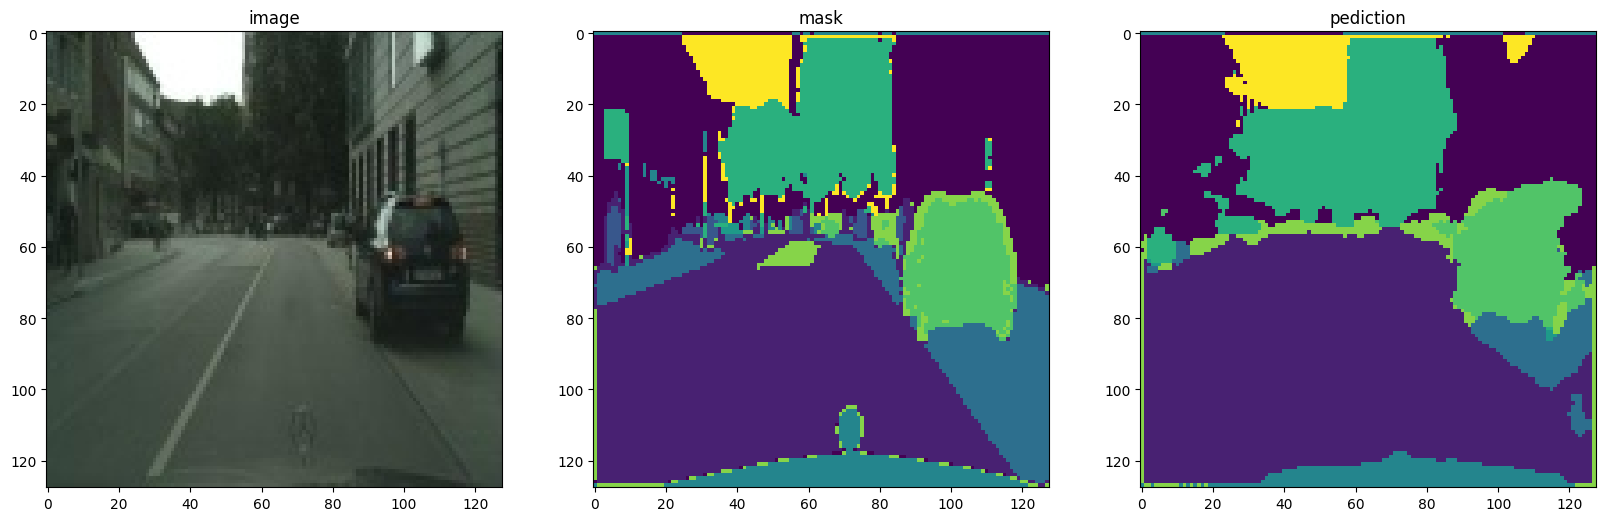

 30%|███       | 3/10 [03:56<09:13, 79.02s/it]

[0.53330492 0.75152593 0.         0.01576197 0.14335142 0.57101766
 0.11664294 0.63729694 0.37905083 0.18470376        nan 0.36343899]
[Epochs-3/10]:
[Train_loss:0.8179 | Train_acc:0.3577 | Val_loss:0.9571 | Val_acc:0.3213]
[0.63598781 0.80028411        nan 0.06921152 0.35867044 0.66568355
 0.15999561 0.63233359 0.50608985 0.22012611        nan 0.52622534]
--------------------
Validation results after 4 epochs:


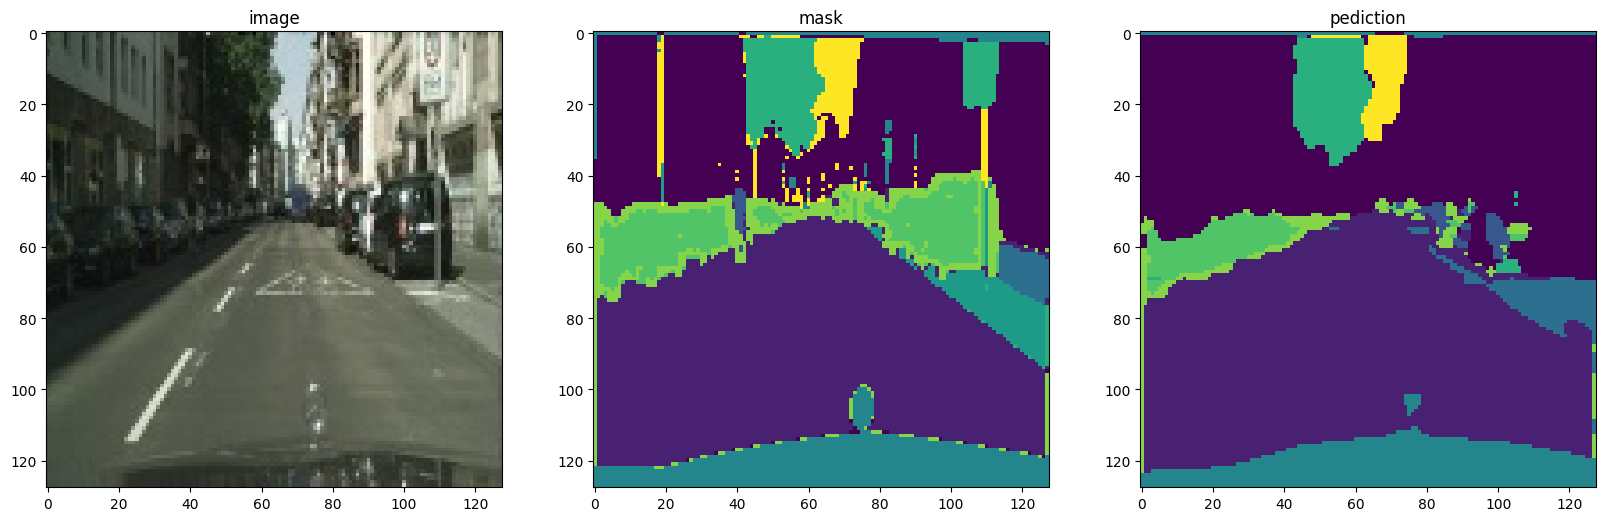

 40%|████      | 4/10 [05:13<07:50, 78.42s/it]

[0.56914435 0.80744111 0.         0.02474158 0.38568363 0.68344408
 0.04906269 0.65604547 0.4770319  0.19175771        nan 0.46657064]
[Epochs-4/10]:
[Train_loss:0.7391 | Train_acc:0.3951 | Val_loss:0.7837 | Val_acc:0.3751]
[0.66476966 0.83687471        nan 0.15824728 0.45506038 0.7223656
 0.17513478 0.66443546 0.58781441 0.25572224        nan 0.54242352]
--------------------
Validation results after 5 epochs:


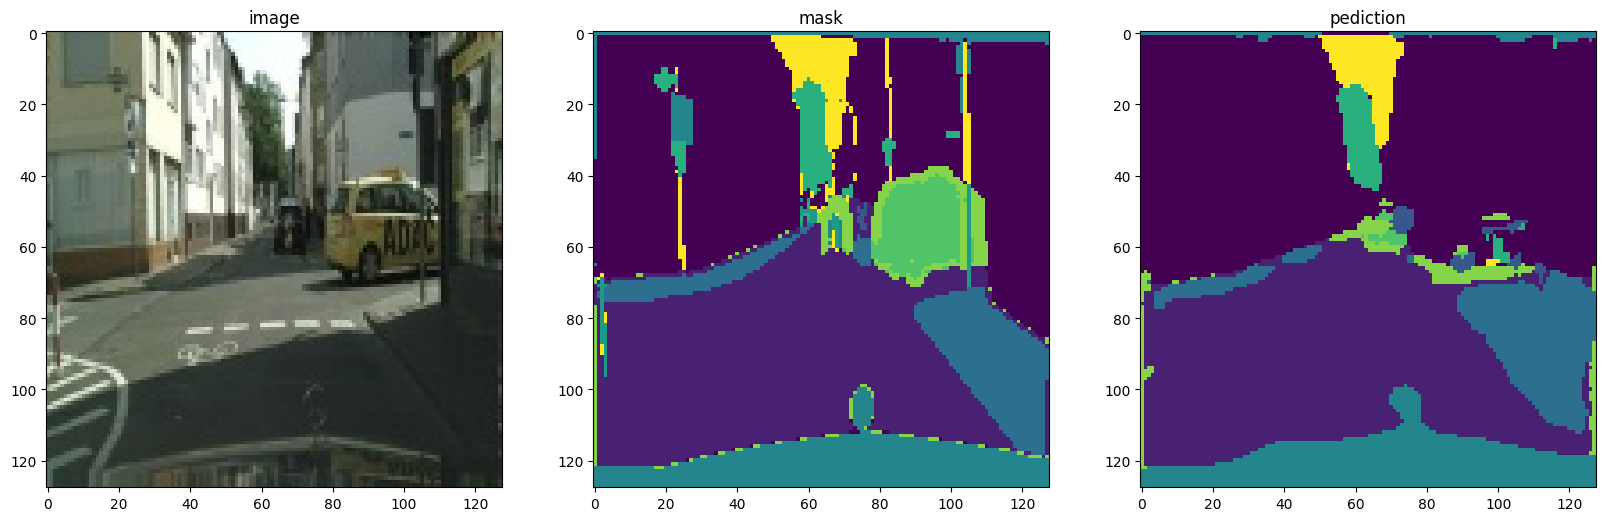

 50%|█████     | 5/10 [06:30<06:30, 78.01s/it]

[0.64841634 0.83180162        nan 0.20079818 0.44652979 0.73758361
 0.13192282 0.69240317 0.56098827 0.24356029        nan 0.49201763]
[Epochs-5/10]:
[Train_loss:0.6470 | Train_acc:0.4378 | Val_loss:0.6516 | Val_acc:0.4365]
[6.75491972e-01 8.43476714e-01 1.12007168e-04 1.92310499e-01
 4.73544492e-01 7.31774722e-01 1.91371565e-01 6.74200549e-01
 6.11856618e-01 2.67468107e-01            nan 5.47611650e-01]
--------------------
Validation results after 6 epochs:


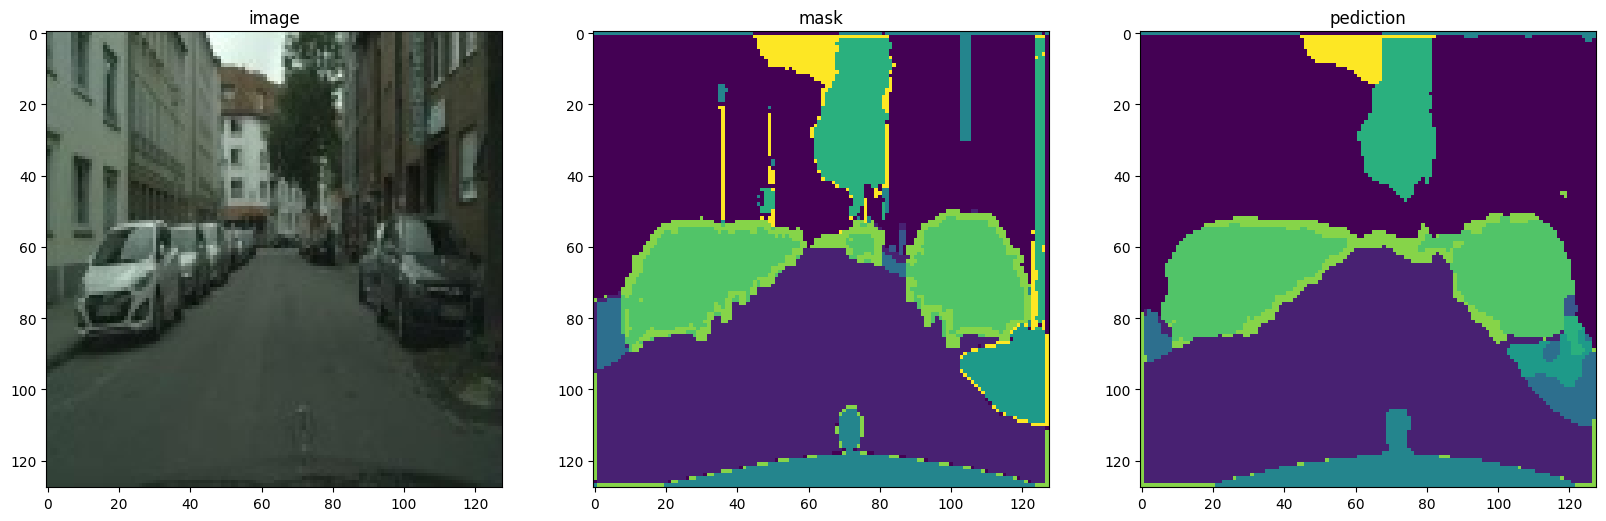

 60%|██████    | 6/10 [07:48<05:11, 77.84s/it]

[0.6592112  0.83325417        nan 0.20847248 0.45861701 0.73810529
 0.13836812 0.69367294 0.58802401 0.24897944        nan 0.49133356]
[Epochs-6/10]:
[Train_loss:0.6230 | Train_acc:0.4502 | Val_loss:0.6400 | Val_acc:0.4391]
[0.68078477 0.84825746        nan 0.1992409  0.48696551 0.73928416
 0.20340966 0.67843723 0.62453525 0.27546814        nan 0.55259474]
--------------------
Validation results after 7 epochs:


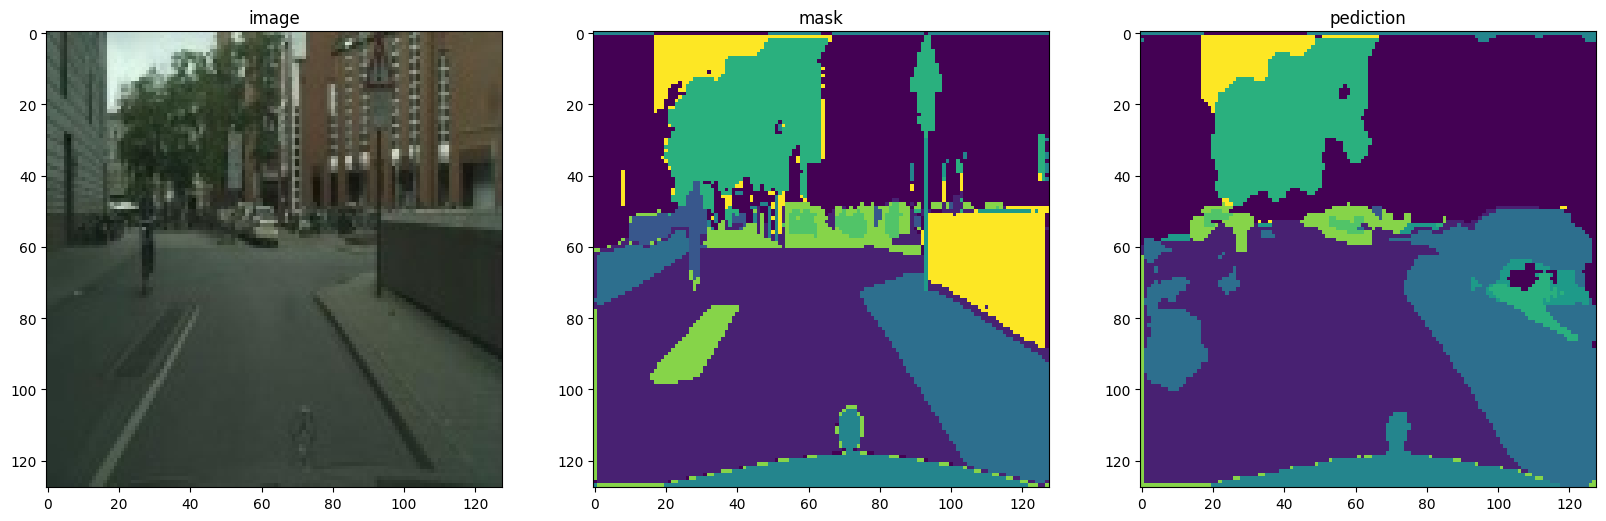

 70%|███████   | 7/10 [09:05<03:52, 77.66s/it]

[0.66899118 0.83311667        nan 0.23566953 0.46485338 0.74456164
 0.14192847 0.68856794 0.60786278 0.25758191        nan 0.49099141]
[Epochs-7/10]:
[Train_loss:0.6074 | Train_acc:0.4576 | Val_loss:645587.2257 | Val_acc:0.4489]
[0.68423052 0.84960036        nan 0.20994792 0.49253246 0.74609277
 0.21500134 0.6816893  0.62693327 0.28446255        nan 0.55294425]
--------------------
Validation results after 8 epochs:


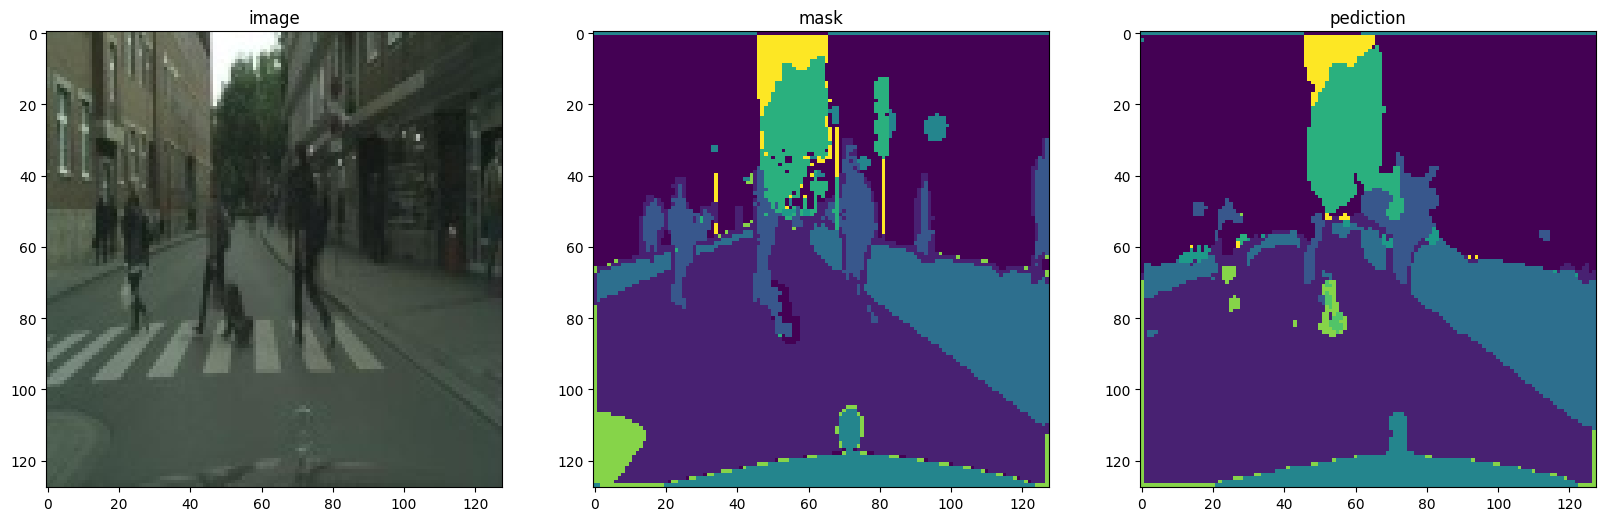

 80%|████████  | 8/10 [10:22<02:34, 77.50s/it]

[0.66559139 0.83861612 0.01192128 0.20516189 0.4650496  0.74129854
 0.16775997 0.69309253 0.61129146 0.27057288        nan 0.49057395]
[Epochs-8/10]:
[Train_loss:0.5975 | Train_acc:0.4649 | Val_loss:5081878.8944 | Val_acc:0.4487]
[0.69281997 0.85715412        nan 0.22324151 0.51283185 0.75308352
 0.22880371 0.69121266 0.64663052 0.29601239        nan 0.55901503]
--------------------
Validation results after 9 epochs:


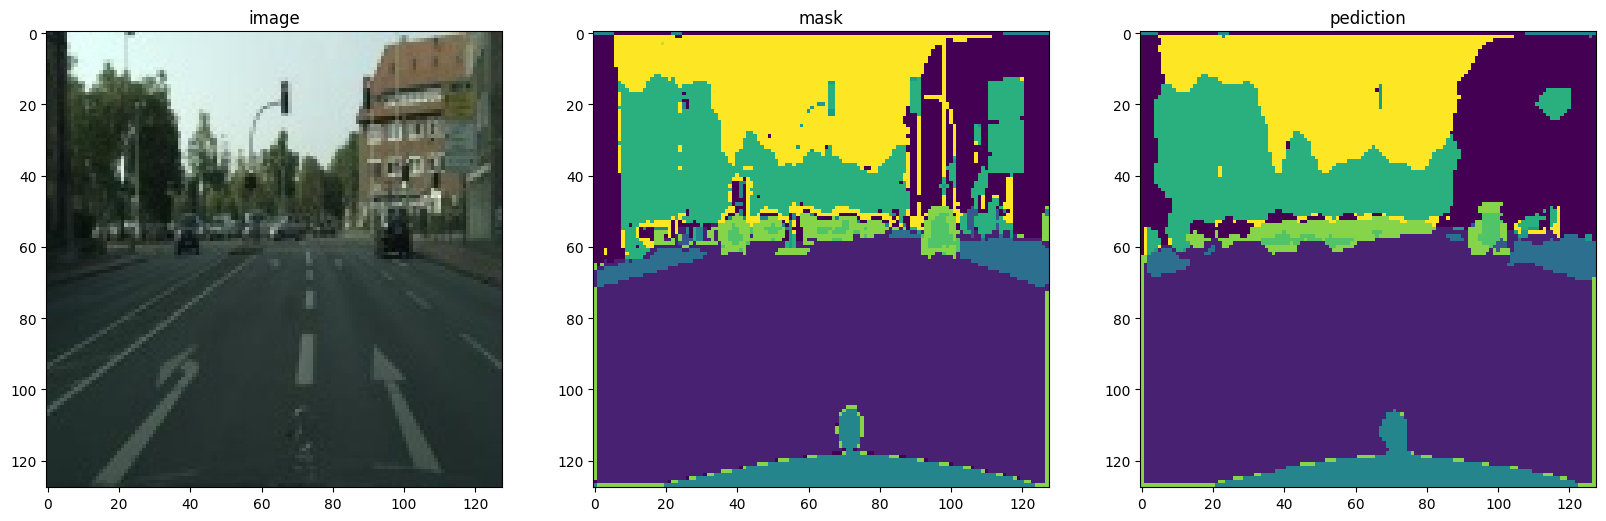

 90%|█████████ | 9/10 [11:39<01:17, 77.27s/it]

[0.66798009 0.84048204        nan        nan 0.47671572 0.75813605
 0.15738119 0.70169362 0.60512204 0.27632029        nan 0.49918243]
[Epochs-9/10]:
[Train_loss:0.5775 | Train_acc:0.4722 | Val_loss:201478.2655 | Val_acc:0.4569]
[0.69377076 0.85743736        nan 0.22806947 0.51410655 0.75454455
 0.22872476 0.6895301  0.65086063 0.29546304        nan 0.56289929]
--------------------
Validation results after 10 epochs:


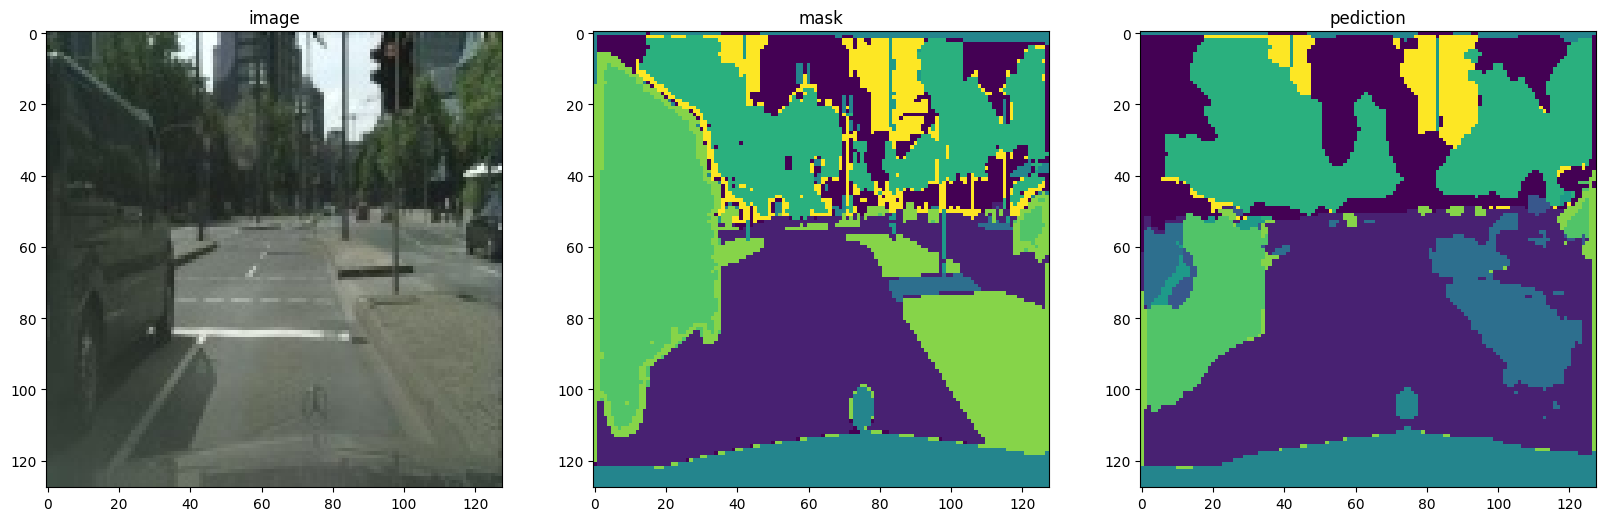

100%|██████████| 10/10 [12:57<00:00, 77.72s/it]

[0.66285081 0.84082471 0.04249658 0.22916409 0.47637234 0.7586644
 0.14047607 0.70351771 0.6122467  0.27339109        nan 0.49645118]
[Epochs-10/10]:
[Train_loss:0.5744 | Train_acc:0.4763 | Val_loss:2.6211 | Val_acc:0.4544]


In [ ]:
trainer.train()

In [ ]:
torch.save(model.state_dict(),"Vanilla-Segnet")

# Augmentation

In [122]:
class Dataset_Augmentation(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)*2

    def __getitem__(self, index):
        index=index%len(self.images_list)
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(25, border_mode=4, p=0.6),

                           A.CoarseDropout(max_holes=20, max_height=int(self.size*0.01),
                                         max_width=int(self.size*0.01), fill_value=255, p=0.4),

                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


# Saving Data

In [123]:


# test_files = glob.glob(os.path.join('./Validation_augmented/Images', '*png'))
# test_files_mask = glob.glob(os.path.join('./Validation_augmented/Masks','*png'))

test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))
test_files.sort()
test_files_mask.sort()
train_data_aug = Dataset_Augmentation(train_files,train_files_mask, INPUT_IMG_SIZE, True, mean=MEAN, std=STD)
val_data_aug = Dataset_Augmentation(test_files, test_files_mask, INPUT_IMG_SIZE, False, mean=MEAN, std=STD)

In [115]:
from torchvision.utils import save_image
print(len(val_data_aug))
for i, (img, msk) in enumerate(val_data_aug):
    print(i)
    img_name = f"image_{i}.png"
    msk_name = f"mask_{i}.png"
    cv2.imwrite(os.path.join("Validation_augmented/Images", img_name),cv2.cvtColor(img*255, cv2.COLOR_BGR2RGB))  # Save the image
    print(msk.shape)
    cv2.imwrite(os.path.join("Validation_augmented/Masks", msk_name),cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))  # Save the mask

500
0
(128, 128, 3)
1
(128, 128, 3)
2
(128, 128, 3)
3
(128, 128, 3)
4
(128, 128, 3)
5
(128, 128, 3)
6
(128, 128, 3)
7
(128, 128, 3)
8
(128, 128, 3)
9
(128, 128, 3)
10
(128, 128, 3)
11
(128, 128, 3)
12
(128, 128, 3)
13
(128, 128, 3)
14
(128, 128, 3)
15
(128, 128, 3)
16
(128, 128, 3)
17
(128, 128, 3)
18
(128, 128, 3)
19
(128, 128, 3)
20
(128, 128, 3)
21
(128, 128, 3)
22
(128, 128, 3)
23
(128, 128, 3)
24
(128, 128, 3)
25
(128, 128, 3)
26
(128, 128, 3)
27
(128, 128, 3)
28
(128, 128, 3)
29
(128, 128, 3)
30
(128, 128, 3)
31
(128, 128, 3)
32
(128, 128, 3)
33
(128, 128, 3)
34
(128, 128, 3)
35
(128, 128, 3)
36
(128, 128, 3)
37
(128, 128, 3)
38
(128, 128, 3)
39
(128, 128, 3)
40
(128, 128, 3)
41
(128, 128, 3)
42
(128, 128, 3)
43
(128, 128, 3)
44
(128, 128, 3)
45
(128, 128, 3)
46
(128, 128, 3)
47
(128, 128, 3)
48
(128, 128, 3)
49
(128, 128, 3)
50
(128, 128, 3)
51
(128, 128, 3)
52
(128, 128, 3)
53
(128, 128, 3)
54
(128, 128, 3)
55
(128, 128, 3)
56
(128, 128, 3)
57
(128, 128, 3)
58
(128, 128, 3)
59


# Testing Old Model

--------------------
Validation results after 1 epochs:


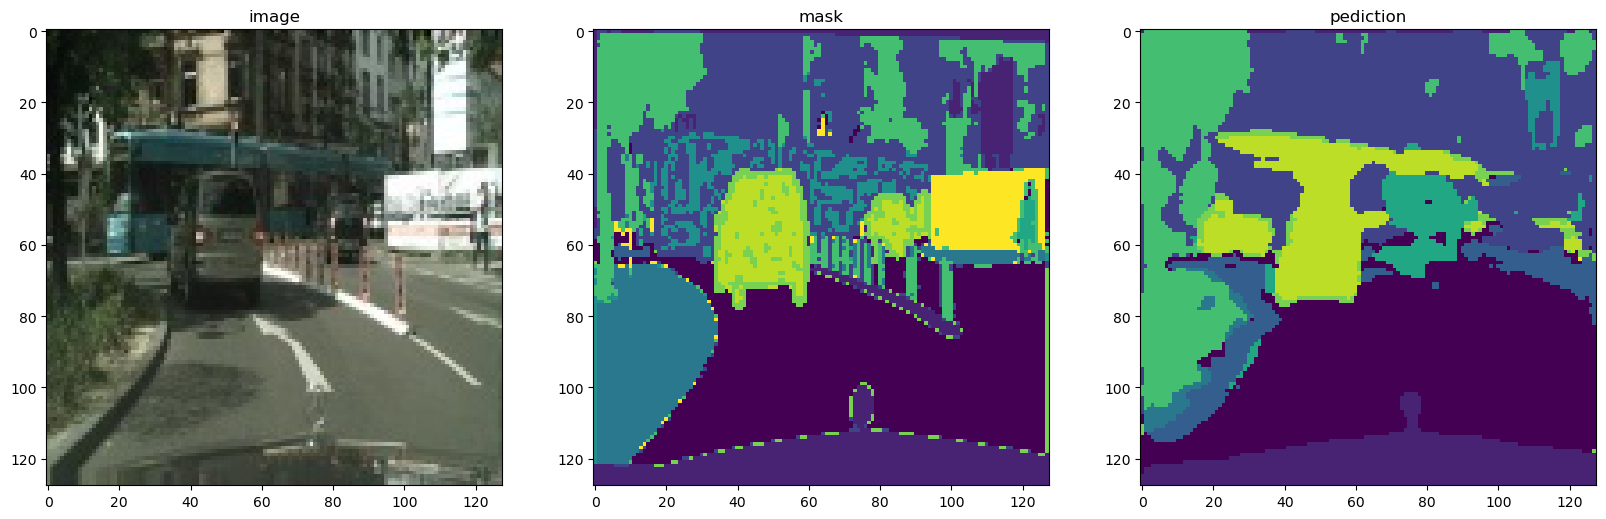

[0.80530003 0.67274601 0.65241934 0.44710656 0.24535908 0.54872109
 0.18996761 0.69498307 0.14544082 0.5735945  0.00952005 0.07251062]


(1.1032362495149886, 0.42147239809732284)

In [121]:
unet_old = Net(num_classes=OUTPUT_CLASSES)
unet_old.load_state_dict(torch.load("Vanilla-Segnet.zip"))
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_aug,
                  val_data = val_data_aug,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

trainer.val_epoch(1)

# Augmented Model

<class 'torch.nn.modules.loss.CrossEntropyLoss'>


  0%|          | 0/10 [00:00<?, ?it/s]

[6.62803407e-01 3.97025853e-01 5.09812637e-01 9.27955465e-02
 1.84911664e-01 4.28587494e-01 8.44835563e-04 5.25457948e-01
 1.63936688e-02 2.54386339e-01 4.81992488e-04 4.22860191e-02]
--------------------
Validation results after 1 epochs:


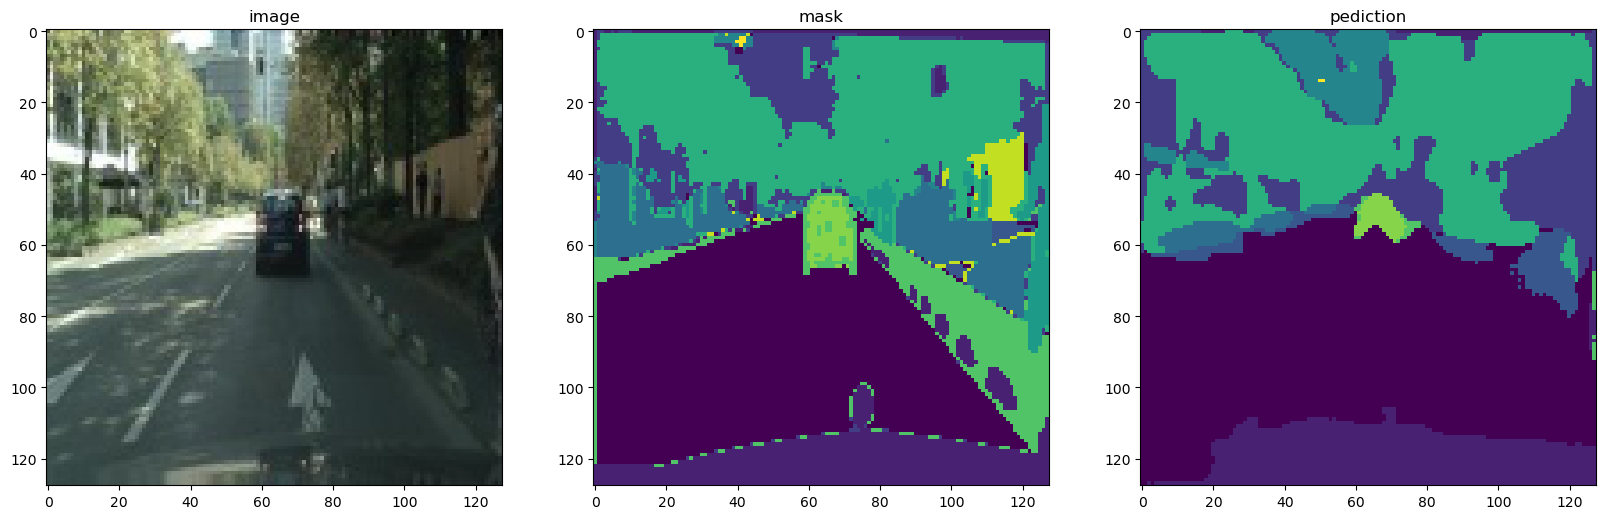

 10%|█         | 1/10 [00:54<08:14, 54.91s/it]

[0.67182655 0.49495426 0.48976877 0.1599955  0.21443846 0.28737338
 0.         0.60872777 0.01742189 0.13057238 0.         0.29724605]
[Epochs-1/10]:
[Train_loss:1.0790 | Train_acc:0.2596 | Val_loss:1.0115 | Val_acc:0.2810]
[0.72829311 0.48083854 0.59733149 0.28630904 0.25575663 0.49172092
 0.03536418 0.60864159 0.07146412 0.43131916 0.00077853 0.04360702]
--------------------
Validation results after 2 epochs:


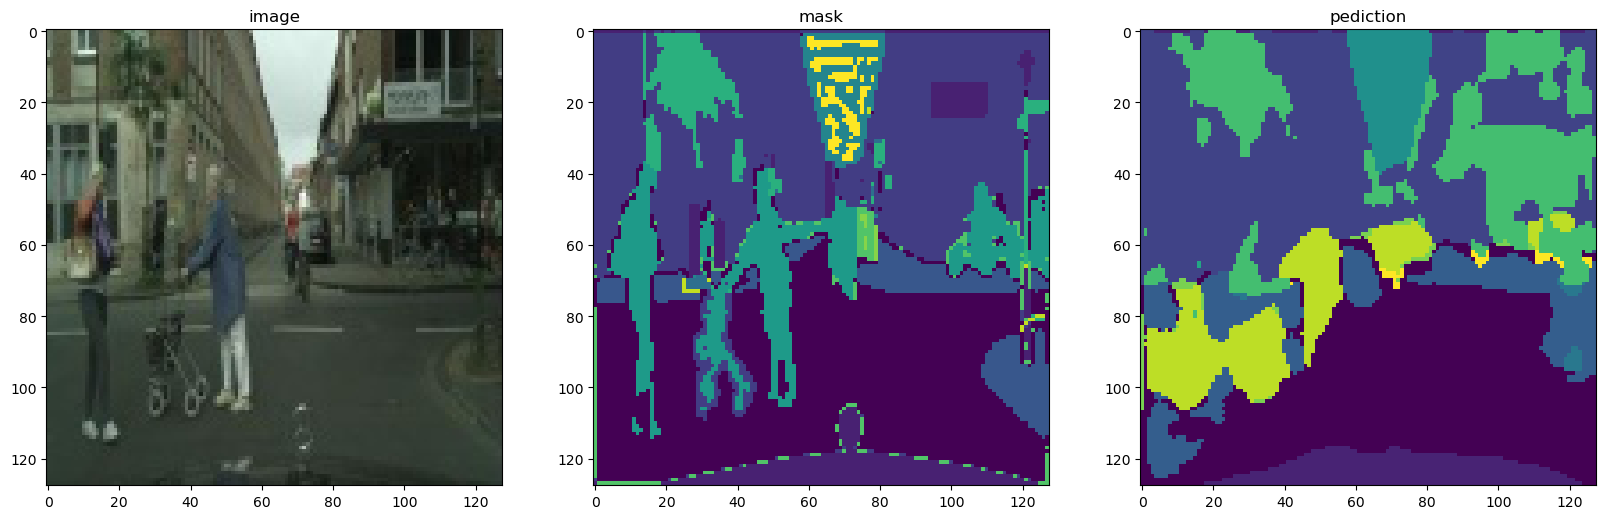

 20%|██        | 2/10 [01:51<07:25, 55.71s/it]

[0.76044447 0.59247931 0.53892548 0.3158691  0.19714858 0.44201353
 0.02680293 0.59455145 0.06135335 0.41052704 0.00740356 0.        ]
[Epochs-2/10]:
[Train_loss:0.8652 | Train_acc:0.3360 | Val_loss:0.8411 | Val_acc:0.3290]
[0.77324821 0.57076219 0.62997119 0.40007897 0.28384511 0.51594435
 0.1149533  0.63219286 0.10407031 0.50519577 0.00898435 0.04031999]
--------------------
Validation results after 3 epochs:


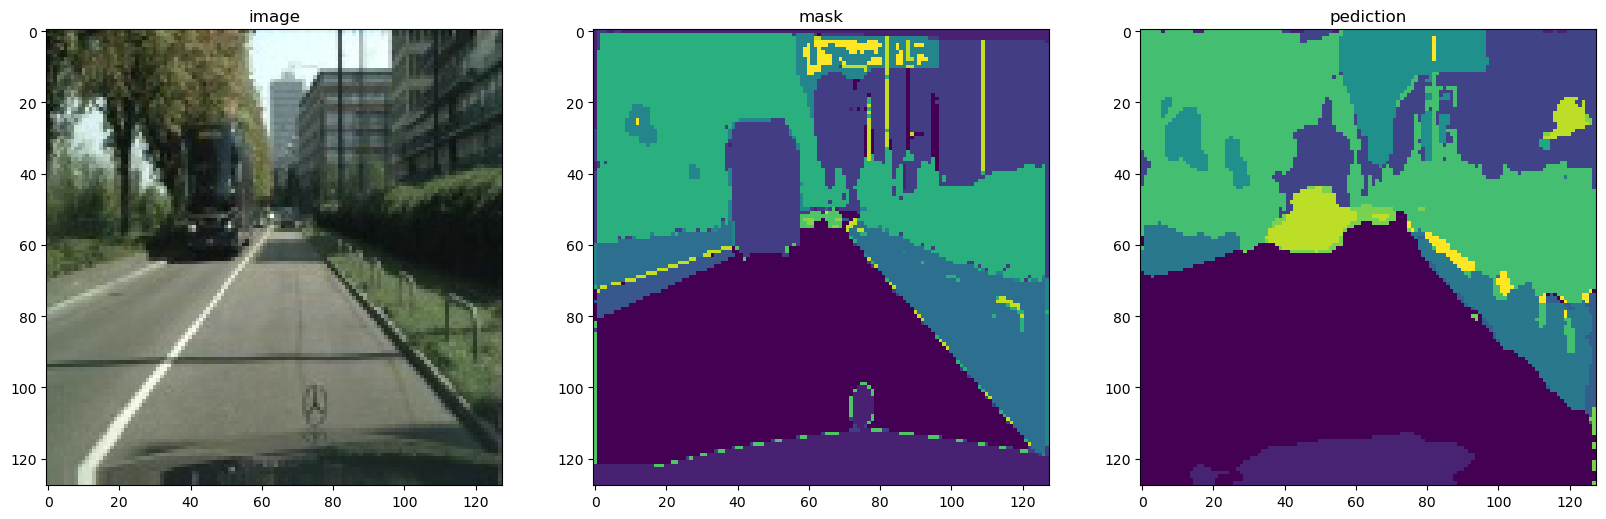

 30%|███       | 3/10 [02:46<06:29, 55.64s/it]

[7.33796892e-01 5.42578391e-01 5.37803177e-01 2.11003197e-01
 2.12090596e-01 3.66465391e-01 1.56611682e-01 6.72358176e-01
 8.53492274e-02 4.77573901e-01 2.48773191e-02 1.23961154e-04]
[Epochs-3/10]:
[Train_loss:0.7635 | Train_acc:0.3816 | Val_loss:61.2116 | Val_acc:0.3351]
[0.79707882 0.62517647 0.65165969 0.45488534 0.28994549 0.52609594
 0.15378803 0.65266381 0.13337166 0.54713764 0.0288395  0.06148638]
--------------------
Validation results after 4 epochs:


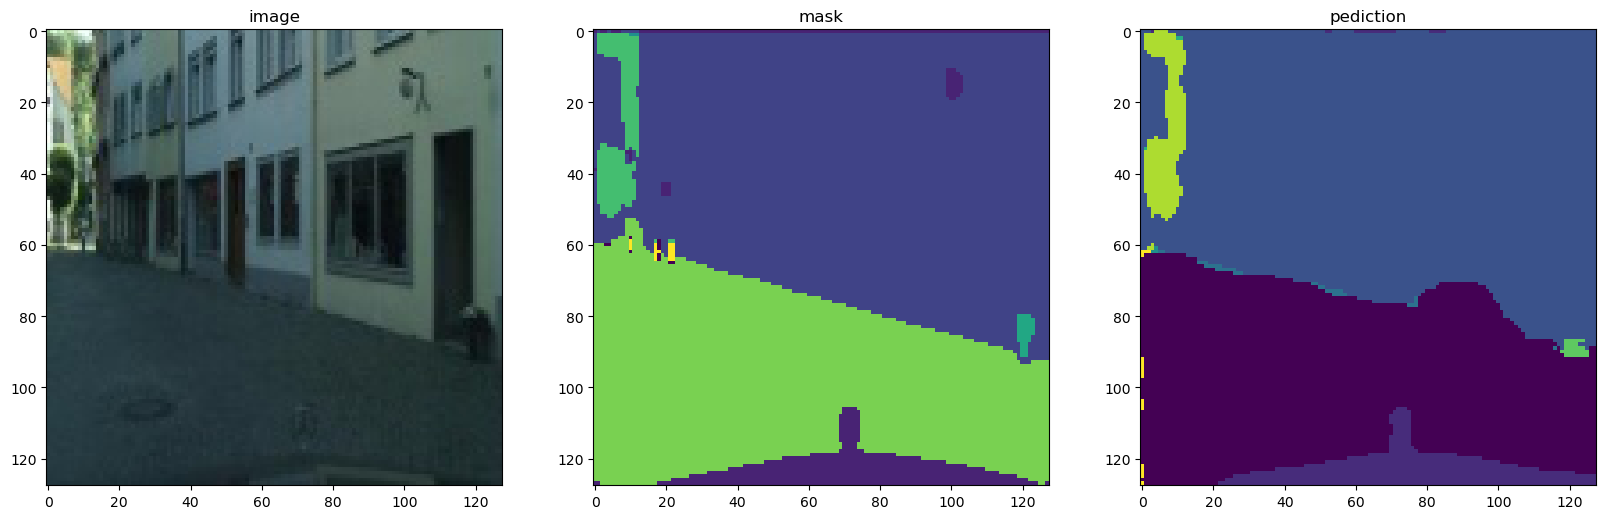

 40%|████      | 4/10 [03:43<05:35, 55.92s/it]

[0.7954426  0.65378436 0.59960088 0.29342614 0.1305331  0.43698133
 0.1047798  0.63846443 0.13684526 0.57653255 0.03235268 0.04367815]
[Epochs-4/10]:
[Train_loss:0.7036 | Train_acc:0.4102 | Val_loss:139.4490 | Val_acc:0.3702]
[0.82336386 0.67087435 0.67937505 0.52608693 0.33771334 0.55063047
 0.19883365 0.67832244 0.16173311 0.59904875 0.06717881 0.08216803]
--------------------
Validation results after 5 epochs:


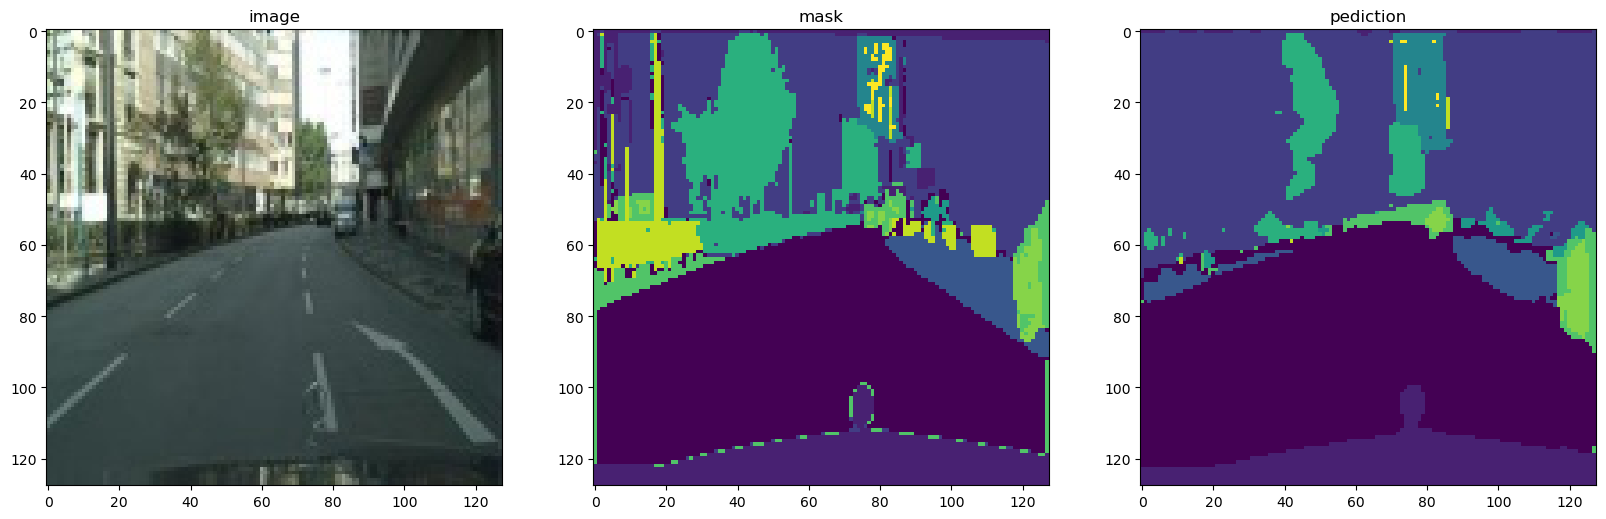

 50%|█████     | 5/10 [04:38<04:39, 55.85s/it]

[0.81718188 0.70601611 0.67332522 0.51415464 0.25892674 0.5497769
 0.22356156 0.7064738  0.16973981 0.60939787 0.05039937 0.08469579]
[Epochs-5/10]:
[Train_loss:0.6250 | Train_acc:0.4479 | Val_loss:512348.7164 | Val_acc:0.4470]
[0.82921963 0.68012955 0.68704869 0.53994271 0.3476143  0.5537208
 0.21109201 0.68537002 0.17317128 0.61061701 0.07990705 0.08230855]
--------------------
Validation results after 6 epochs:


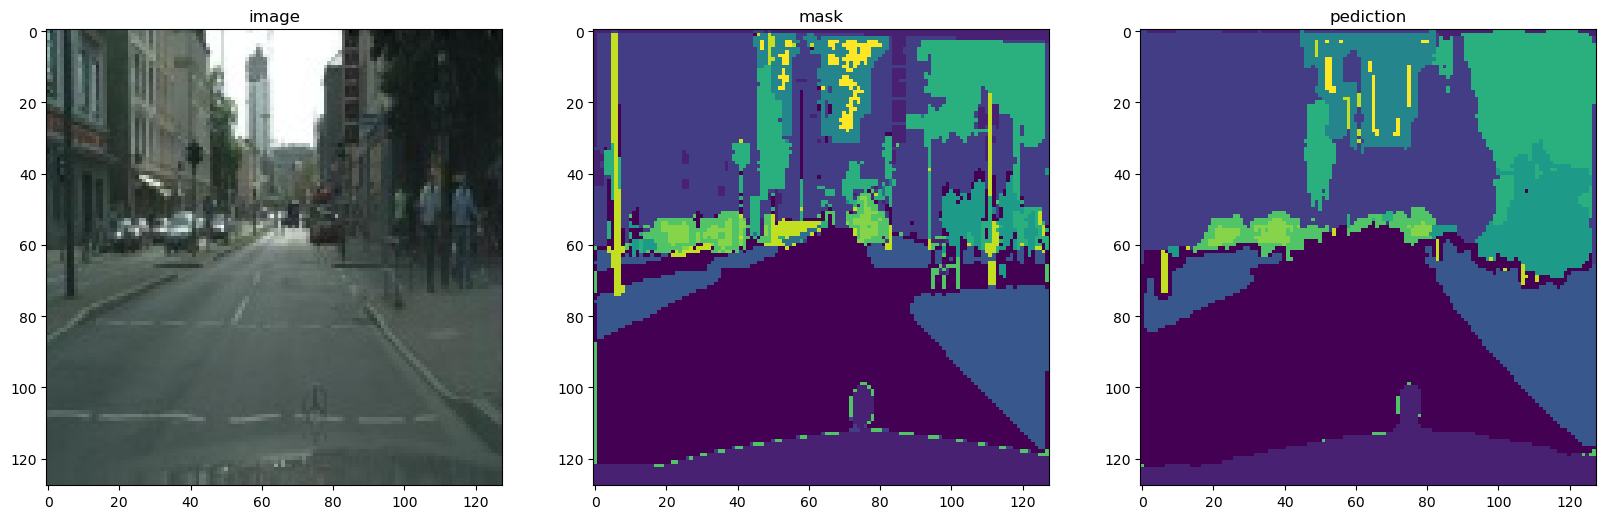

 60%|██████    | 6/10 [05:34<03:43, 55.92s/it]

[0.82413987 0.71080568 0.66699482 0.52315528 0.25933192 0.53743151
 0.22976026 0.69644021 0.20046339 0.60429631 0.06814122 0.11981628]
[Epochs-6/10]:
[Train_loss:0.6049 | Train_acc:0.4567 | Val_loss:182959.9672 | Val_acc:0.4534]
[0.83282099 0.68723841 0.69263413 0.55401237 0.36101311 0.55785271
 0.22156679 0.69155983 0.17951239 0.61927087 0.09350684 0.07929025]
--------------------
Validation results after 7 epochs:


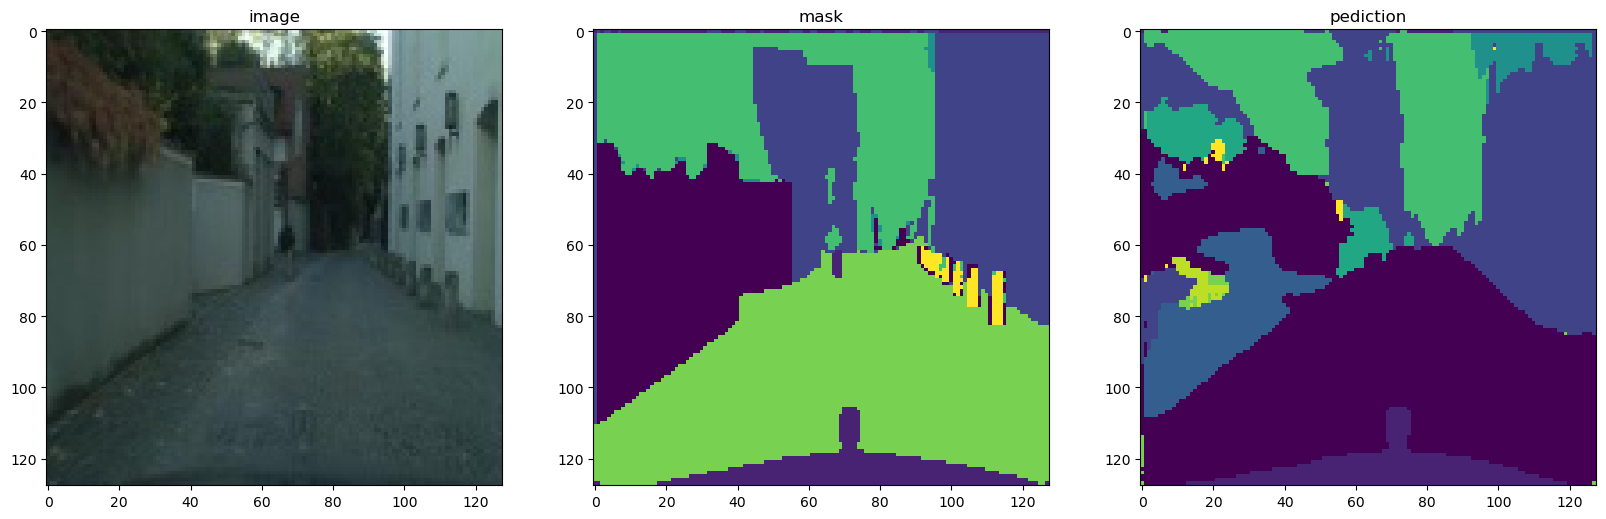

 70%|███████   | 7/10 [06:30<02:47, 55.87s/it]

[0.82441137 0.72312363 0.67478224 0.5081227  0.25259774 0.54465732
 0.23318728 0.71383568 0.19790766 0.60123815 0.06312975 0.14807617]
[Epochs-7/10]:
[Train_loss:0.5913 | Train_acc:0.4642 | Val_loss:67883.7292 | Val_acc:0.4571]
[0.83648276 0.6906126  0.69668301 0.5648963  0.35754712 0.55963442
 0.22802334 0.6977456  0.1862093  0.62524225 0.10426484 0.08360082]
--------------------
Validation results after 8 epochs:


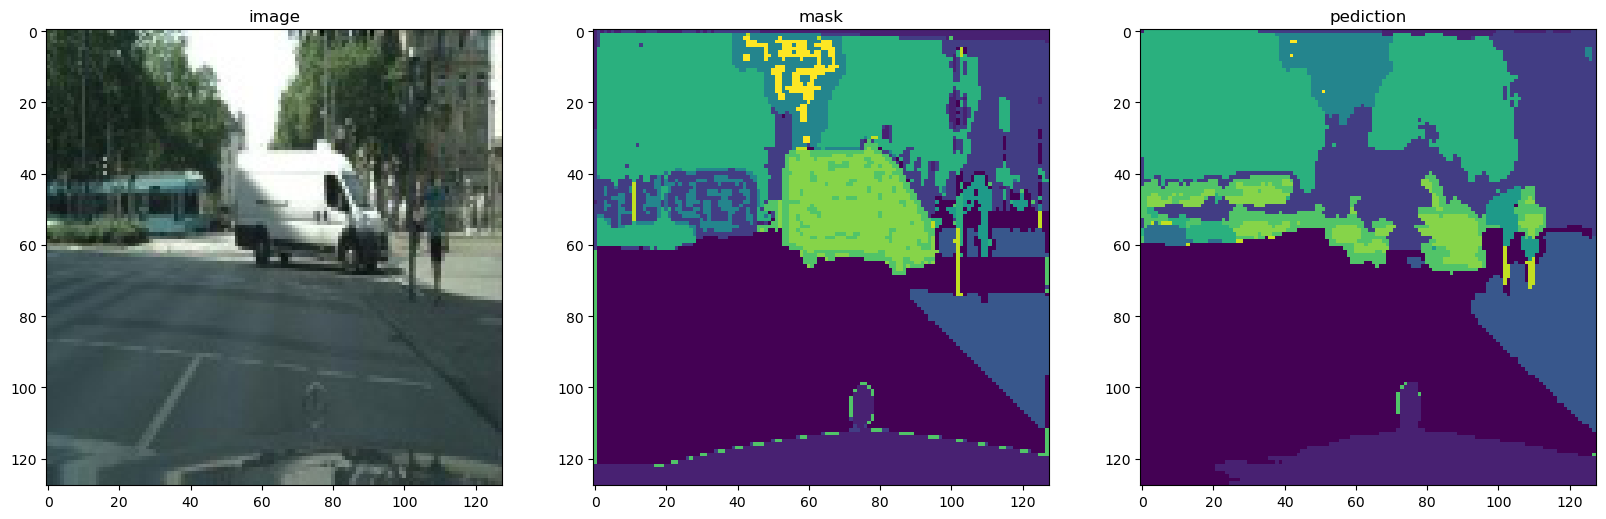

 80%|████████  | 8/10 [07:26<01:51, 55.80s/it]

[0.82937781 0.72336663 0.67990449 0.53067064 0.27997772 0.56658694
 0.24162856 0.71192048 0.21268469 0.60872749 0.08588259 0.14779122]
[Epochs-8/10]:
[Train_loss:0.5794 | Train_acc:0.4692 | Val_loss:573110.6488 | Val_acc:0.4682]
[0.84131203 0.69654904 0.70510202 0.58021449 0.37314728 0.56198284
 0.24180699 0.70576853 0.19596059 0.63186889 0.11766578 0.09072121]
--------------------
Validation results after 9 epochs:


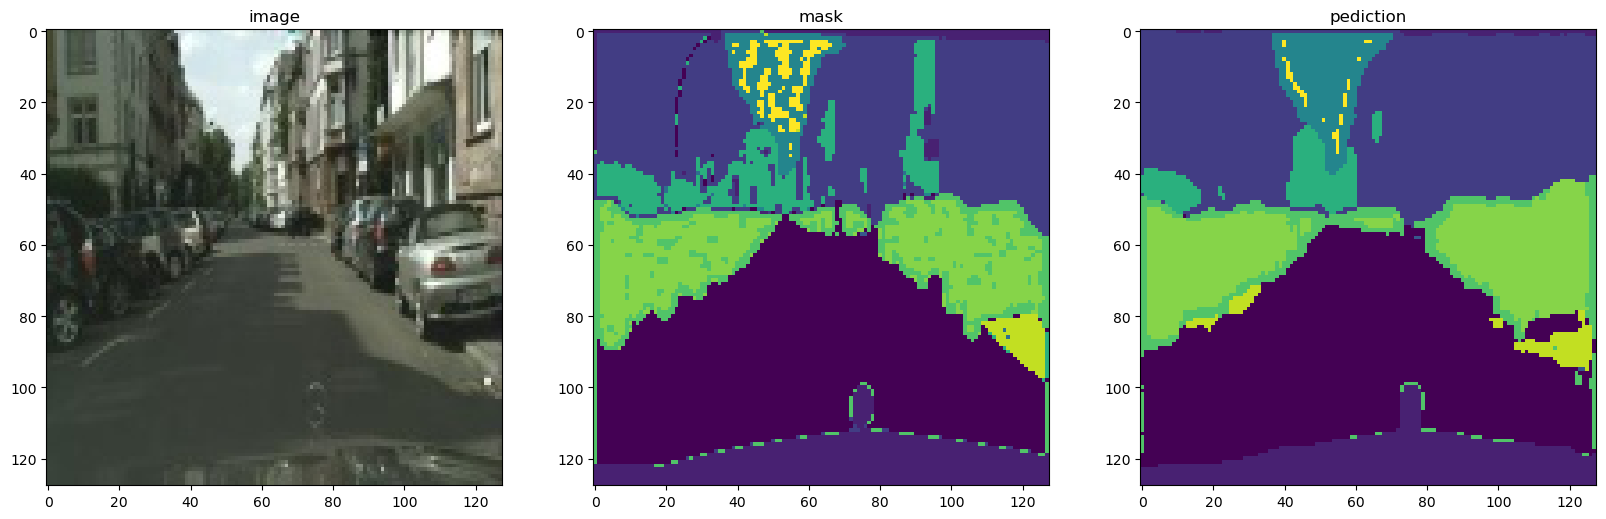

 90%|█████████ | 9/10 [08:21<00:55, 55.69s/it]

[0.83216066 0.72696696 0.6854786  0.53691844 0.29322051 0.57168526
 0.24246527 0.71469049 0.21591393 0.62232884 0.07487985 0.08233316]
[Epochs-9/10]:
[Train_loss:0.5608 | Train_acc:0.4785 | Val_loss:207240.3137 | Val_acc:0.4666]
[0.84301857 0.69595318 0.70749505 0.58102231 0.36932482 0.56490347
 0.24703069 0.71021487 0.19766797 0.63563263 0.12635652 0.08491366]
--------------------
Validation results after 10 epochs:


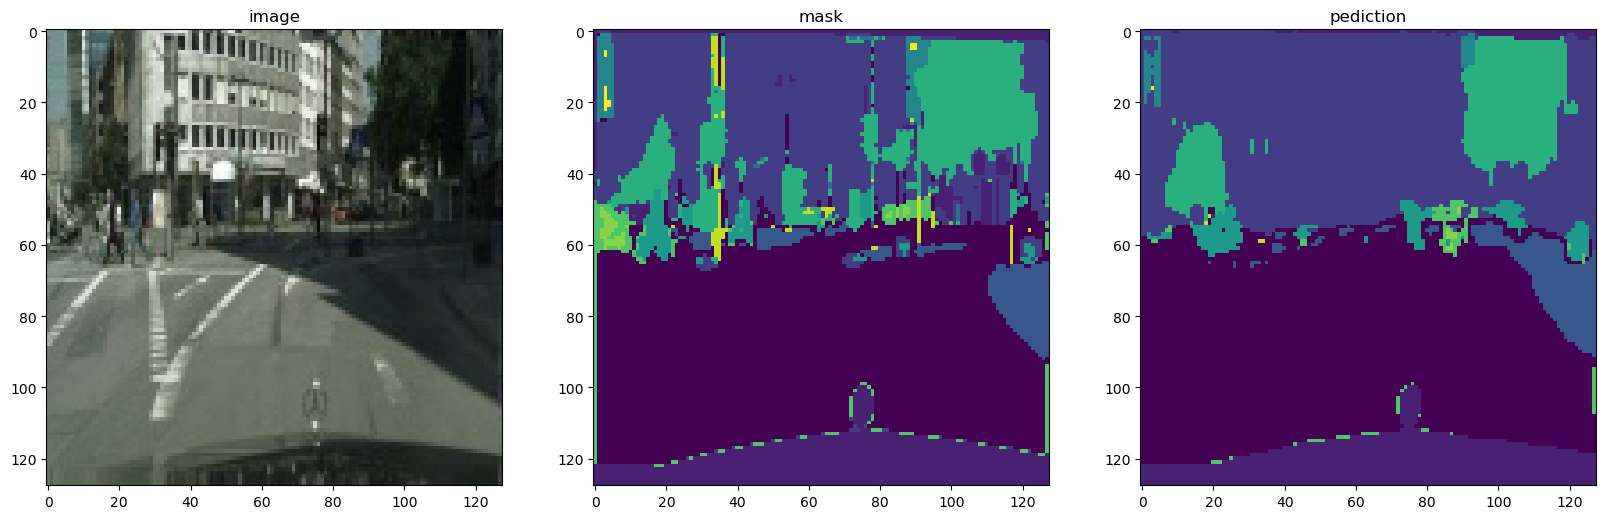

100%|██████████| 10/10 [09:17<00:00, 55.80s/it]

[0.82971882 0.72418265 0.68690114 0.53099349 0.29458705 0.5702627
 0.24233629 0.71710914 0.20543355 0.62626736 0.0759947  0.0904208 ]
[Epochs-10/10]:
[Train_loss:0.5567 | Train_acc:0.4803 | Val_loss:516915.0826 | Val_acc:0.4662]


In [124]:
unet = Net(num_classes=OUTPUT_CLASSES)
model = unet
loss_function = nn.CrossEntropyLoss()
print(type(loss_function))
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_aug,
                  val_data = val_data_aug,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )
trainer.train()

In [125]:
torch.save(model.state_dict(),"SegNet-Aug")